# Scans Sessions Analysis (ephax Quickstart Style)

This notebook loads recording sessions from `data/Scans` (or `ephax/data/Scans`) and runs the same core analyses as `ephax_quickstart.ipynb`.


In [1]:
%matplotlib inline
import re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

from ephax import RestingActivityDataset, PrepConfig, LayoutGridPlotter, DCTAnalyzer
from ephax.analyzers import IFRAnalyzer
from ephax.analyzers.ifr import IFRConfig
from ephax.analyzers.firing_distance import FiringDistanceAnalyzer
from ephax.analyzers.cofiring_temporal import CofiringTemporalAnalyzer, CofiringTemporalConfig

plt.rcParams["figure.dpi"] = 120
np.random.seed(0)


/Users/danielrebbin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danielrebbin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Configure Session Loading

- Set `START_SEC`, `END_SEC`, and `MIN_AMP` as needed.
- For `.h5` files, wells are inferred from filenames like `...well_0...`.
- Use `WELL_OVERRIDES` when a filename does not include a well number.


In [2]:
START_SEC = 0
END_SEC = 300
MIN_AMP = 0

WELL_OVERRIDES = {
    # "my_recording_file.raw.h5": 0,
}

scan_dir_candidates = [
    Path("data/Scans"),
    Path("ephax/data/Scans"),
    Path("Scans"),
]
scan_dir = next((p for p in scan_dir_candidates if p.exists()), None)
if scan_dir is None:
    raise FileNotFoundError(
        "Could not find Scans directory. Expected one of: "
        + ", ".join(str(p) for p in scan_dir_candidates)
    )

npz_files = sorted(scan_dir.rglob("*.npz"))
h5_files = sorted(scan_dir.rglob("*.raw.h5")) + sorted(scan_dir.rglob("*.h5"))
h5_files = sorted(set(h5_files))

if npz_files:
    source = "npz"
    file_info = [(str(p), START_SEC, END_SEC, 0) for p in npz_files]
elif h5_files:
    source = "h5"

    def infer_well(path: Path):
        name = path.name
        if name in WELL_OVERRIDES:
            return int(WELL_OVERRIDES[name])
        m = re.search(r"well[_-]?(\d+)", name, flags=re.IGNORECASE)
        return int(m.group(1)) if m else None

    unresolved = []
    file_info = []
    for p in h5_files:
        well = infer_well(p)
        if well is None:
            unresolved.append(p.name)
            continue
        file_info.append((str(p.parent), p.name, START_SEC, END_SEC, well))

    if unresolved:
        raise ValueError(
            "Could not infer well number for these files: "
            + ", ".join(unresolved)
            + ". Add them to WELL_OVERRIDES."
        )
else:
    raise FileNotFoundError(f"No .npz or .h5 files found under {scan_dir}")

print(f"Using Scans directory: {scan_dir}")
print(f"Detected source type: {source}")
print(f"Number of sessions: {len(file_info)}")
for entry in file_info[:10]:
    print("  ", entry)
if len(file_info) > 10:
    print(f"  ... and {len(file_info) - 10} more")


Using Scans directory: ephax/data/Scans
Detected source type: npz
Number of sessions: 24
   ('ephax/data/Scans/M09068/250811/data_well_1_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/M09072/250811/data_well_1_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003638/250801/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003638/250804/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003638/250806/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003638/250811/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003643/250801/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003643/250804/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003643/250806/data_well_0_exp_data.npz', 0, 300, 0)
   ('ephax/data/Scans/P003643/250811/data_well_0_exp_data.npz', 0, 300, 0)
  ... and 14 more


In [3]:
ds = RestingActivityDataset.from_file_info(file_info, source=source, min_amp=MIN_AMP)
print(f"Loaded {len(ds.recordings)} recordings")
print(f"Sampling rate: {ds.sf}")


Loaded 24 recordings
Sampling rate: [20000.]


## Exclude Low-Activity Recordings

Use this block to remove recordings with too little activity before running analyses. All downstream cells use the filtered dataset.


In [ ]:
# Automatic + manual exclusion settings
MIN_TOTAL_SPIKES = 300          # exclude recordings below this spike count in [START_SEC, END_SEC]
MIN_ACTIVE_ELECTRODES = 25      # exclude recordings with fewer active electrodes
MANUAL_EXCLUDE_IDX = []         # e.g., [0, 14, 16, 21, 22, 23]

kept_recordings = []
activity_rows = []

for rec_idx, rec in enumerate(ds.recordings):
    duration = float(rec.end_time - rec.start_time)
    n_spikes = int(len(rec.spikes.get("time", [])))
    n_active_electrodes = int(np.unique(rec.spikes.get("electrode", np.array([], dtype=int))).size)
    mean_hz = (n_spikes / duration) if duration > 0 else 0.0

    auto_exclude = (n_spikes < MIN_TOTAL_SPIKES) or (n_active_electrodes < MIN_ACTIVE_ELECTRODES)
    manual_exclude = rec_idx in MANUAL_EXCLUDE_IDX
    keep = not (auto_exclude or manual_exclude)

    activity_rows.append({
        "recording_idx": rec_idx,
        "duration_s": round(duration, 3),
        "n_spikes": n_spikes,
        "n_active_electrodes": n_active_electrodes,
        "mean_spike_rate_hz": mean_hz,
        "auto_exclude": auto_exclude,
        "manual_exclude": manual_exclude,
        "keep": keep,
    })

    if keep:
        kept_recordings.append(rec)

import pandas as pd
activity_summary = pd.DataFrame(activity_rows)
print(f"Original recordings: {len(ds.recordings)}")
print(f"Kept recordings: {len(kept_recordings)}")
print(f"Excluded recordings: {len(ds.recordings) - len(kept_recordings)}")

excluded_idx = activity_summary.loc[~activity_summary["keep"], "recording_idx"].tolist()
print("Excluded recording indices:", excluded_idx)

if not kept_recordings:
    raise ValueError("All recordings were excluded. Relax thresholds or clear MANUAL_EXCLUDE_IDX.")

# Rebuild dataset for all downstream analyses
ds = RestingActivityDataset(recordings=kept_recordings, sf=ds.sf)
activity_summary


## Layout Grid Visualizations

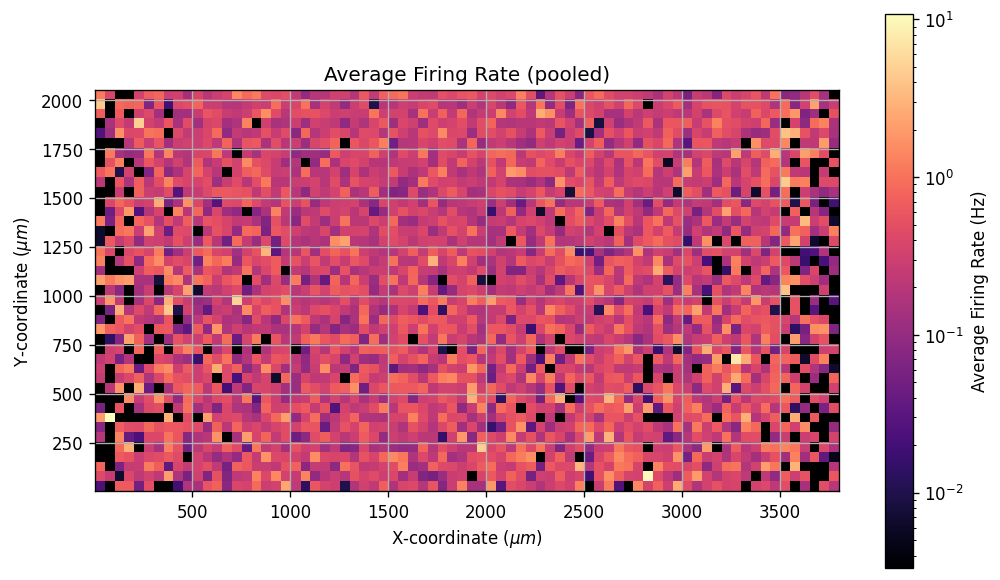

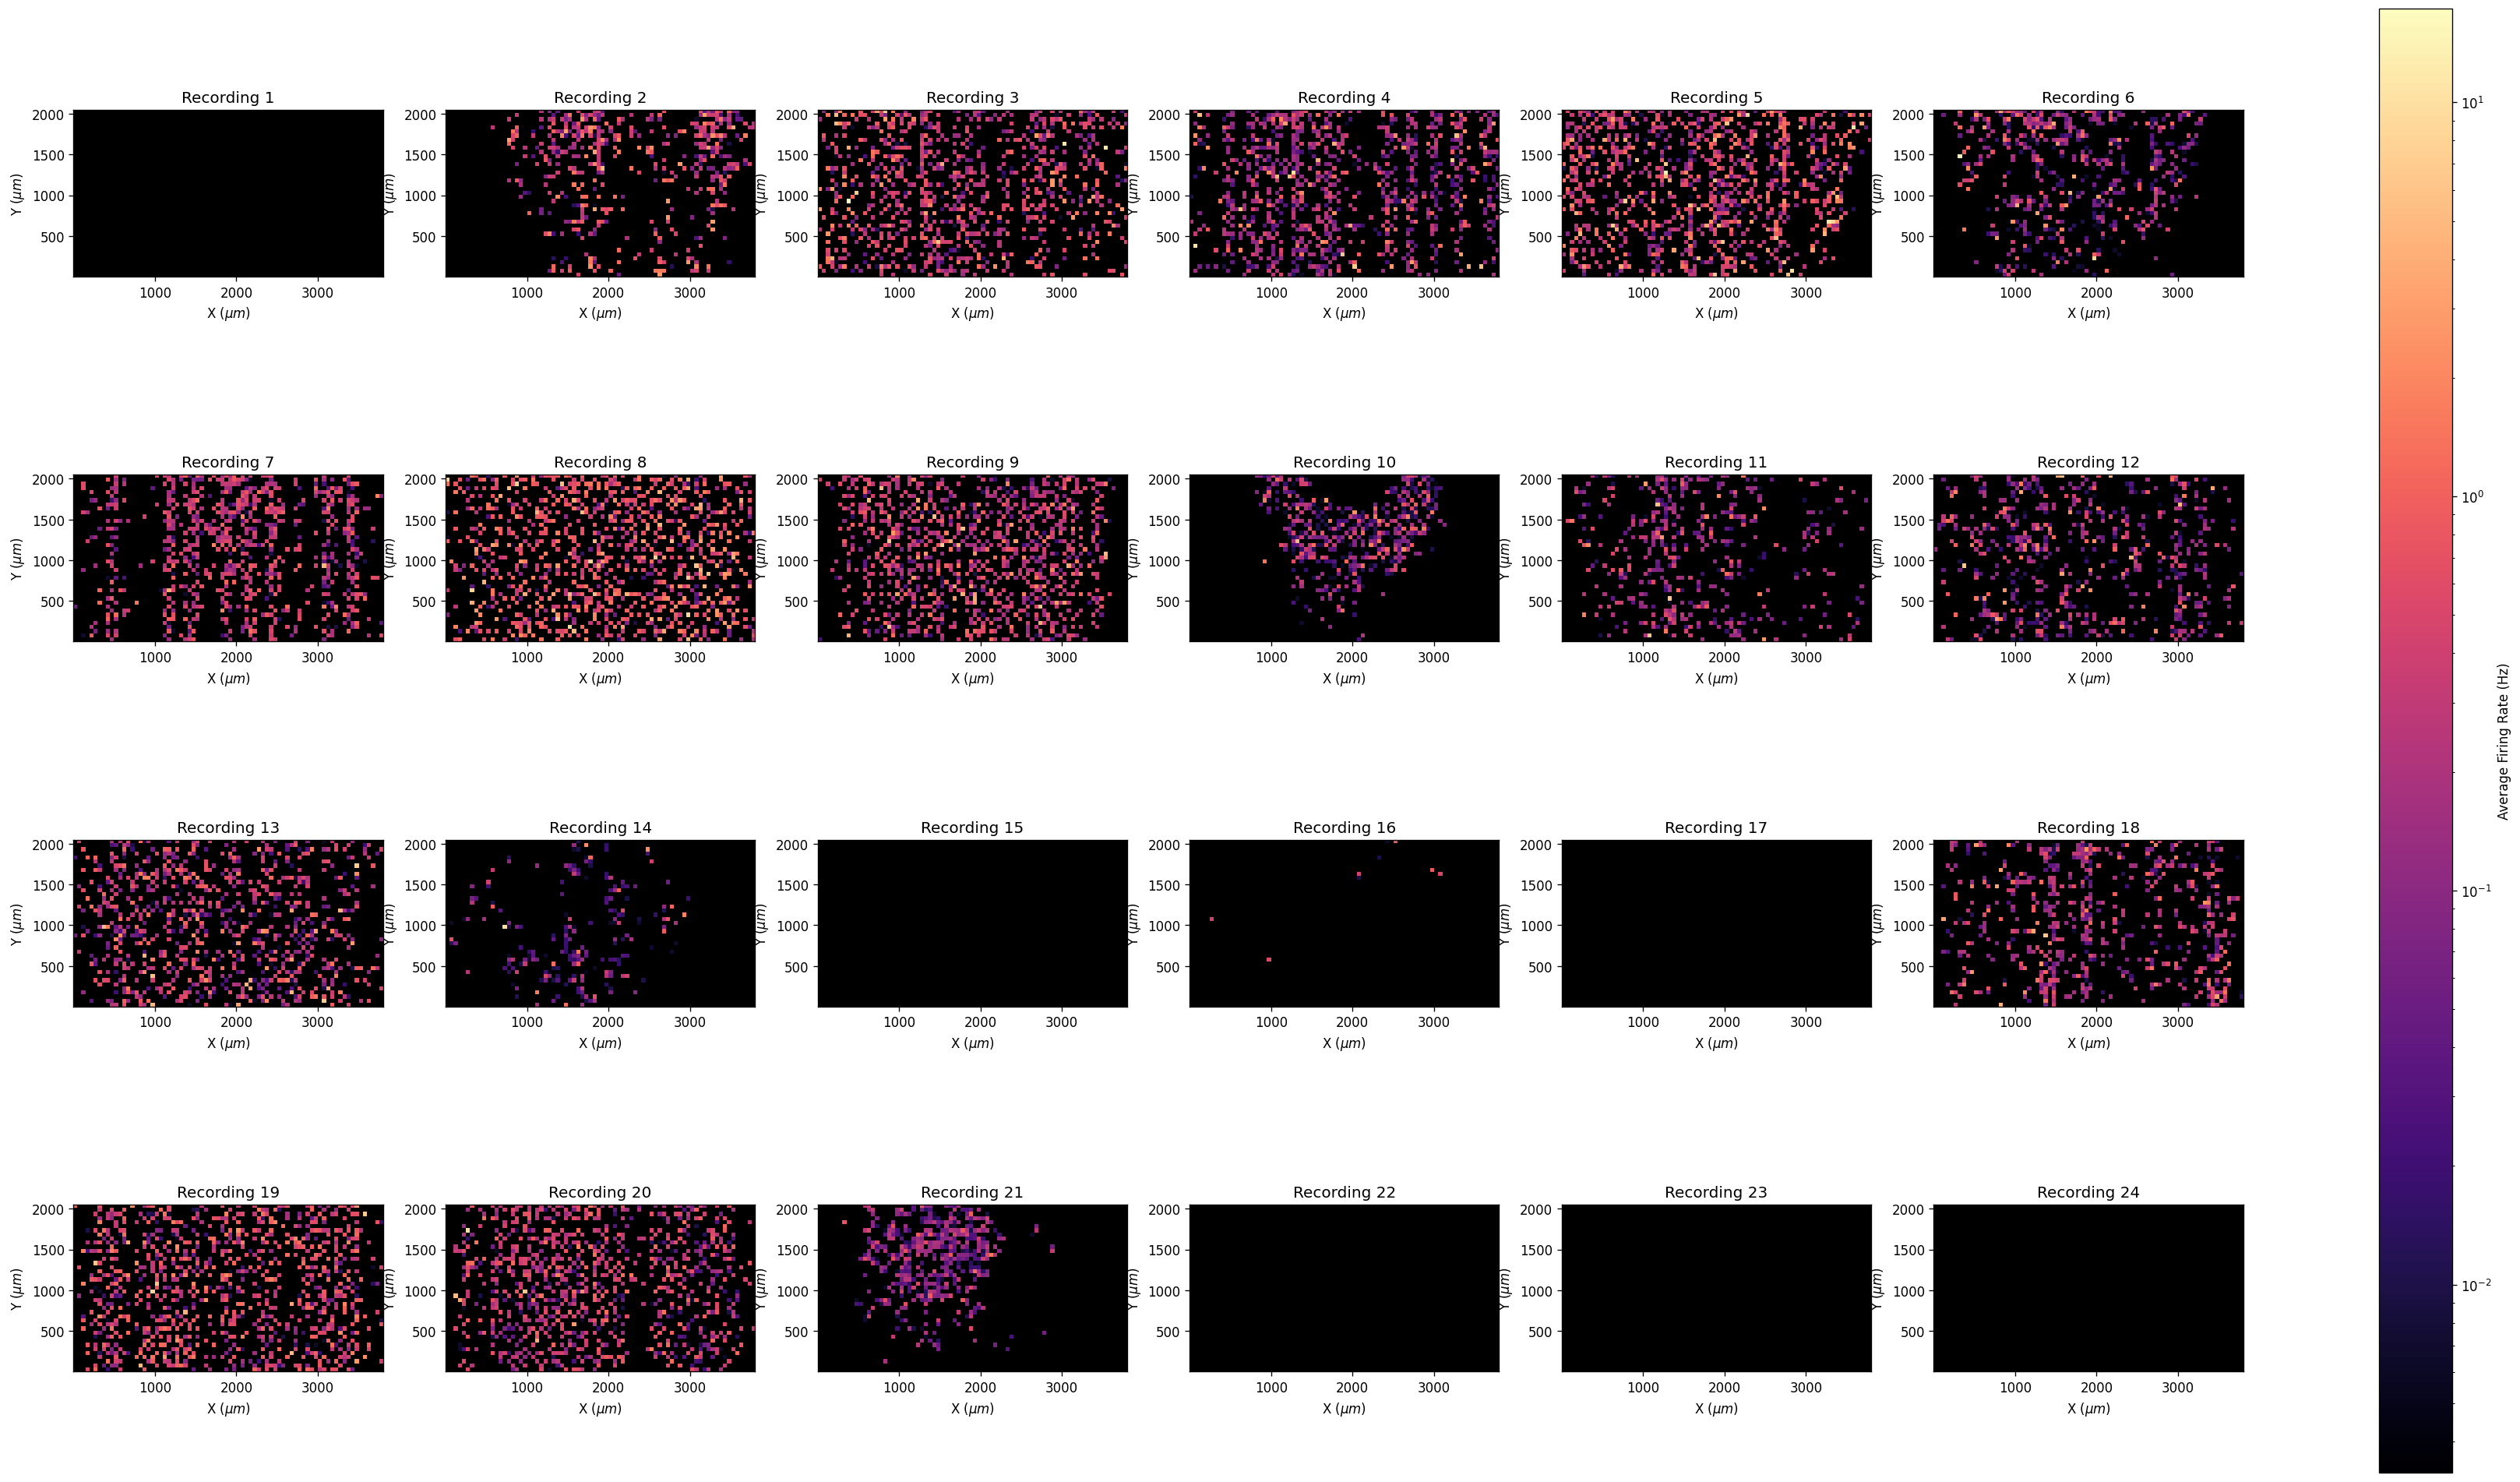

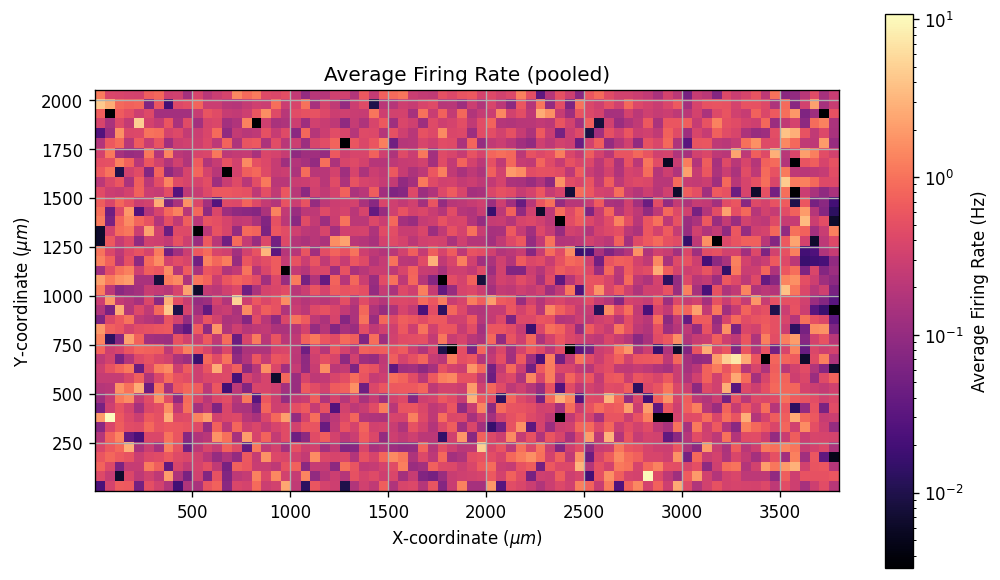

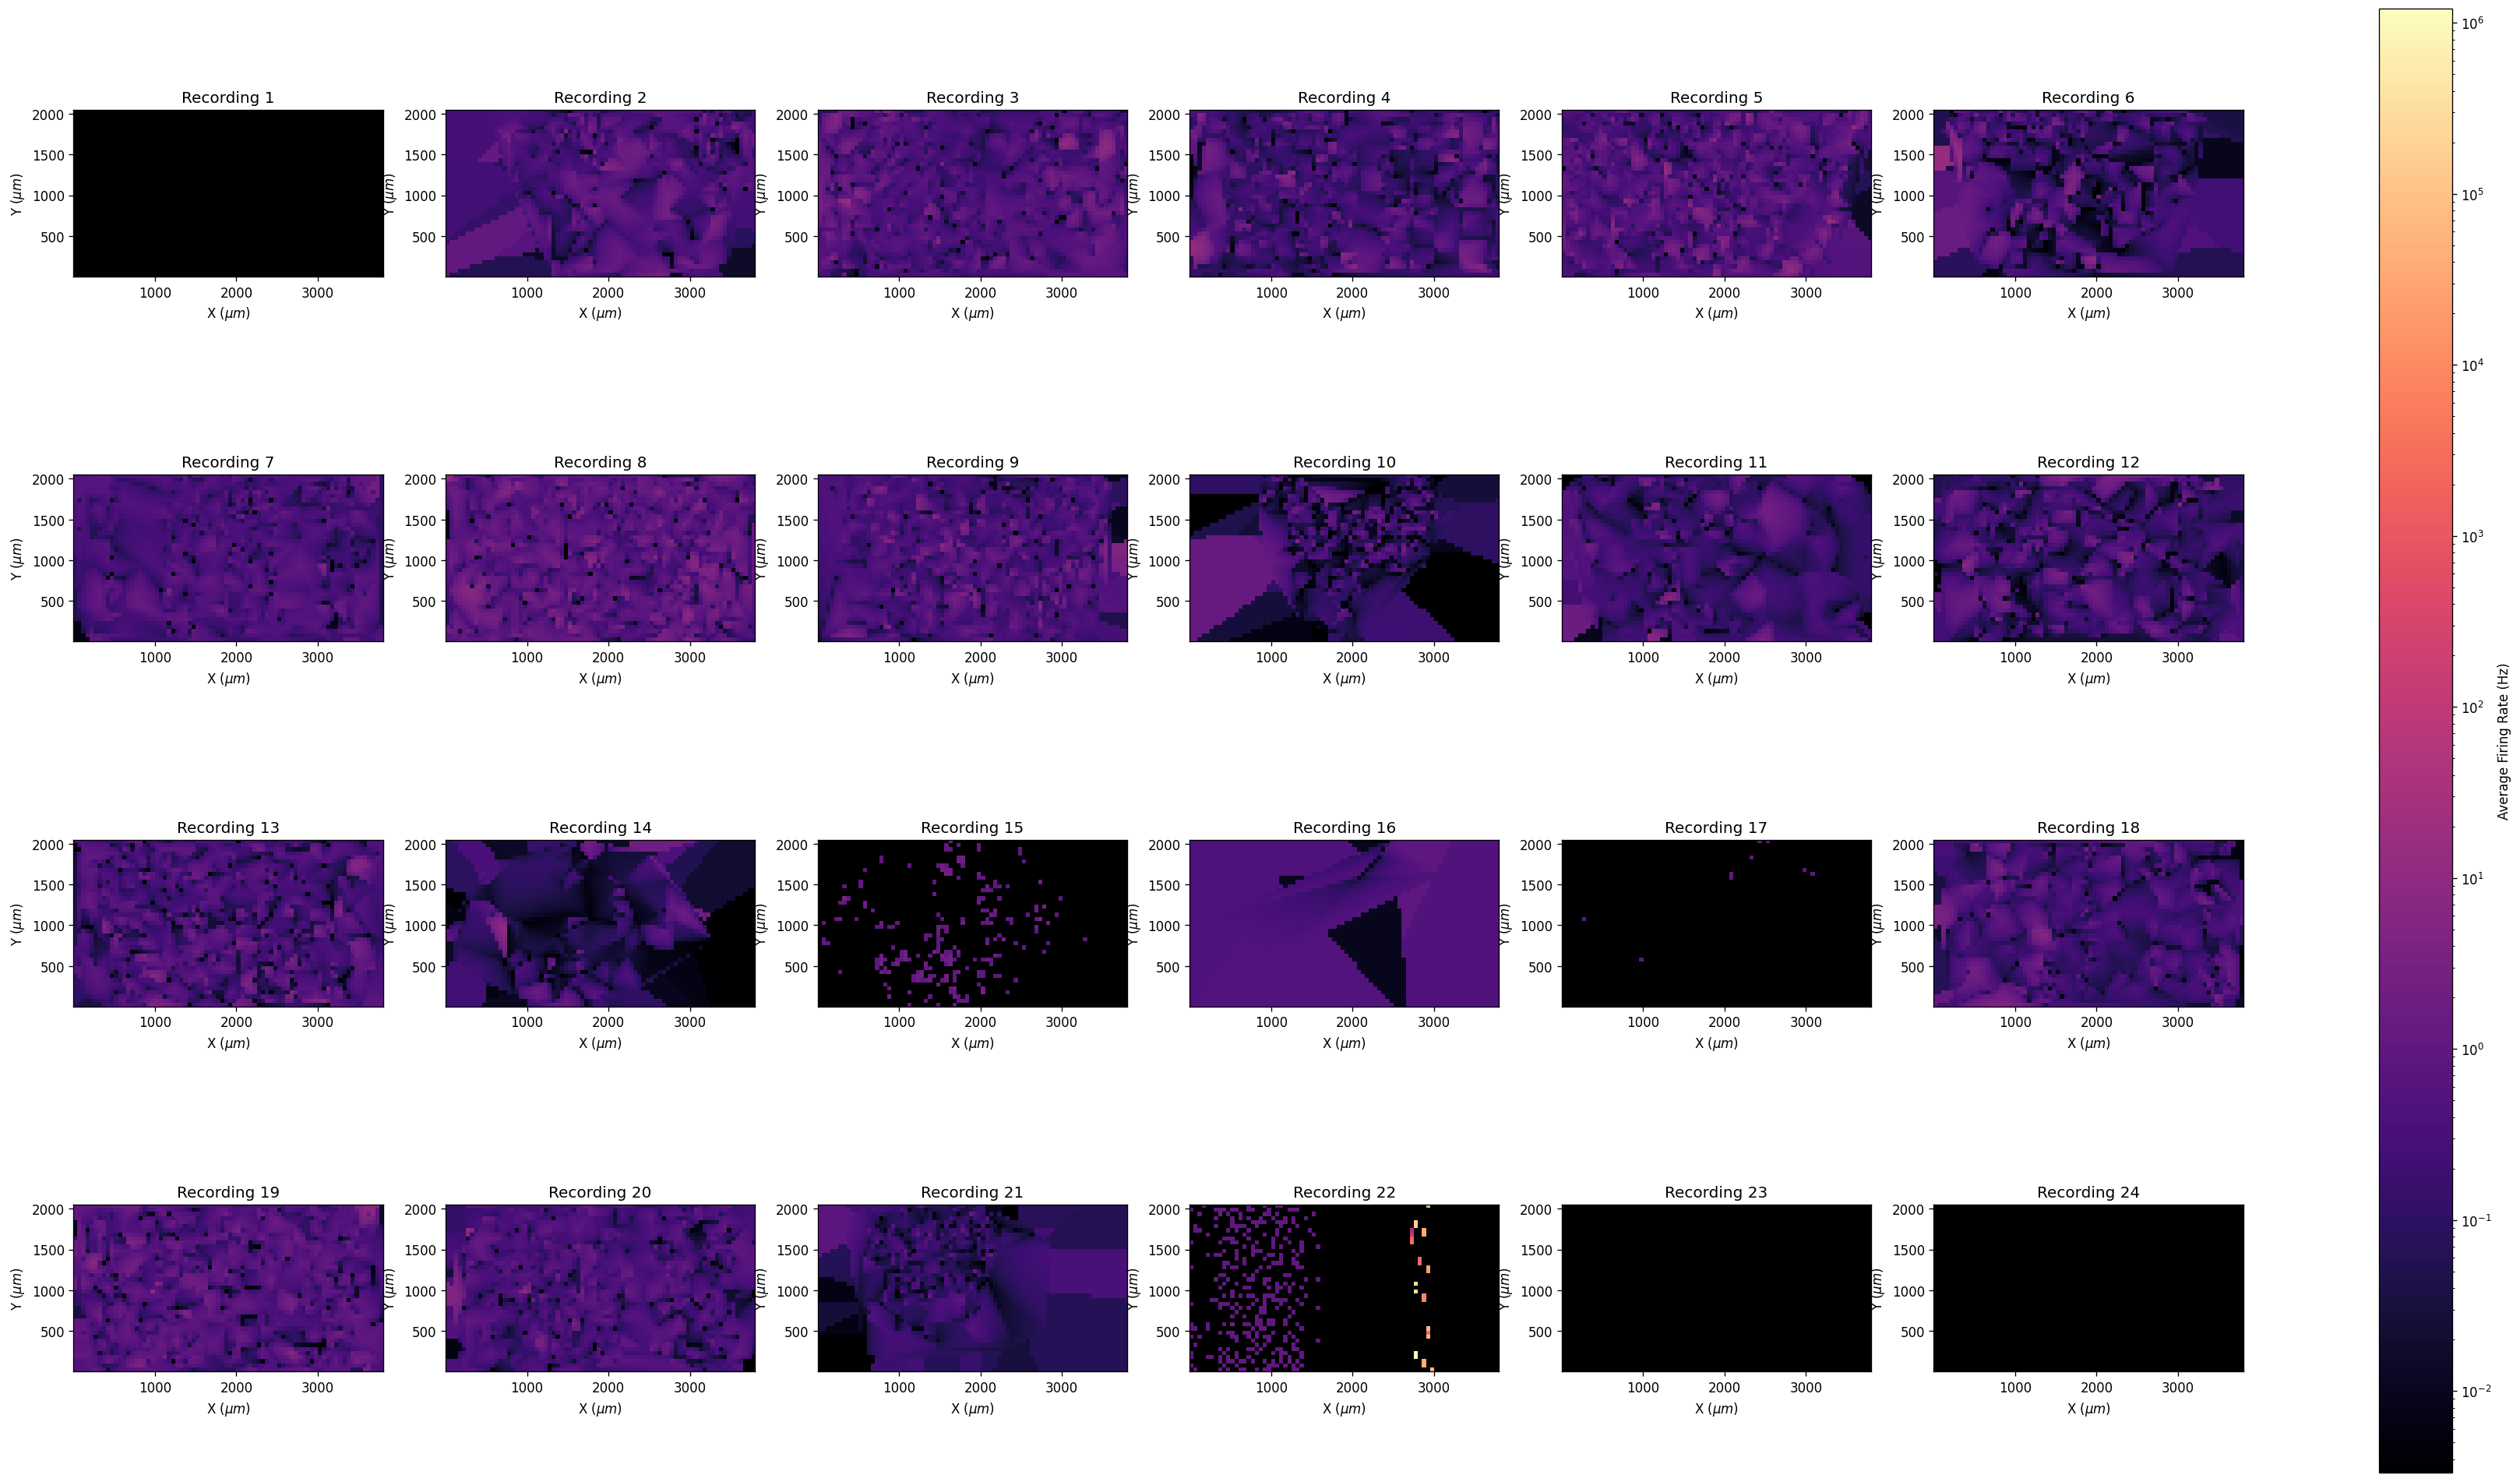

(<Figure size 3600x1920 with 25 Axes>,
 array([[<Axes: title={'center': 'Recording 1'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 2'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 3'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 4'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 5'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 6'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>],
        [<Axes: title={'center': 'Recording 7'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 8'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 9'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,
         <Axes: title={'center': 'Recording 10'}, xlabel='X ($\\mu m$)', ylabel='Y ($\\mu m$)'>,

In [4]:
lg = LayoutGridPlotter(ds)

# Without interpolation
lg.plot_grid_avghz_pooled(grid_size=50.0, interpolate=False)
lg.plot_grid_avghz_panel(grid_size=50.0, ncols=6, interpolate=False)

# With interpolation
lg.plot_grid_avghz_pooled(grid_size=50.0, interpolate=True)
lg.plot_grid_avghz_panel(grid_size=50.0, ncols=6, interpolate=True)


## Select Reference Electrodes

In [5]:
top_stop = 100
prep_cfg = PrepConfig(mode="top", top_start=0, top_stop=top_stop, verbose=False)
refs_per_recording = ds.select_ref_electrodes(prep_cfg)

for idx, refs in enumerate(refs_per_recording):
    preview = ", ".join(map(str, refs[:5])) + ("..." if refs.size > 5 else "")
    print(f"Recording {idx}: selected {refs.size} reference electrodes ({preview})")


Recording 0: selected 0 reference electrodes ()
Recording 1: selected 100 reference electrodes (19983, 22762, 9395, 24076, 22523...)
Recording 2: selected 100 reference electrodes (11682, 20853, 20222, 25788, 13008...)
Recording 3: selected 100 reference electrodes (10597, 4843, 16132, 18223, 1875...)
Recording 4: selected 100 reference electrodes (15913, 8768, 22864, 6311, 822...)
Recording 5: selected 100 reference electrodes (18720, 11280, 2972, 20584, 7780...)
Recording 6: selected 100 reference electrodes (11615, 5984, 7987, 4945, 19260...)
Recording 7: selected 100 reference electrodes (4569, 2508, 12642, 25081, 24251...)
Recording 8: selected 100 reference electrodes (15047, 2030, 5656, 17482, 15451...)
Recording 9: selected 100 reference electrodes (15696, 18392, 19051, 19969, 22095...)
Recording 10: selected 100 reference electrodes (16349, 1162, 6675, 20966, 14758...)
Recording 11: selected 100 reference electrodes (11901, 25609, 21512, 13339, 14804...)
Recording 12: selected

## Instantaneous Firing Rate (IFR)

In [ ]:
ifr_cfg = IFRConfig(
    log_scale=True,
    hist_bins=2000,
    overlay_gmm=True,
    time_grid_hz=200.0,
    max_time_points=2_000,
)
ifr_analyzer = IFRAnalyzer.from_dataset(ds, config=ifr_cfg, selection_prep_config=prep_cfg)
peaks = ifr_analyzer.peaks()

print(f"Collected {peaks.values.size} IFR samples")
if peaks.peaks_hz.size:
    print("GMM peak locations (Hz):", np.round(peaks.peaks_hz, 2))
else:
    print("No peaks detected; consider widening the selection window.")


In [ ]:
ifr_analyzer.plot_histogram()

In [ ]:
ifr_analyzer.plot_timeseries()

## Distance-Dependent Firing Statistics

In [ ]:
shuffle_layout_coordinates = True
permute_for_null = True
num_permutations = 2
perm_seed = 12345

perm_datasets = []
if permute_for_null:
    for perm_idx in range(num_permutations):
        permuted_recs = []
        for rec_idx, rec in enumerate(ds.recordings):
            seed = None if perm_seed is None else perm_seed + perm_idx * 1000 + rec_idx
            permuted_recs.append(
                rec.randomize_electrode_mapping(
                    seed=seed,
                    inplace=False,
                    shuffle_layout_coordinates=shuffle_layout_coordinates,
                )
            )
        perm_datasets.append(RestingActivityDataset(recordings=permuted_recs, sf=ds.sf))

fd_perm_dataset = perm_datasets[0] if perm_datasets else None
fd_analyzer = FiringDistanceAnalyzer(
    ds,
    dataset_perm=fd_perm_dataset,
    selection_prep_config=prep_cfg,
    v_eph=0.1,
    v_ax=0.45,
)

plusminus_ms = 2.0
rate_vs_distance = fd_analyzer.avg_rate_vs_distance()
fd_analyzer.plot_rate_with_synergy(rate_vs_distance, show_exponential_fit=True)

cof_res = fd_analyzer.cofiring_avg_vs_distance(plusminus_ms=plusminus_ms, log=False)
fd_analyzer.plot_cofiring_with_synergy(cof_res)


## Temporal Co-firing Heatmap

In [ ]:
cft_cfg = CofiringTemporalConfig(start_ms=-20, stop_ms=20, step_ms=1, normalize=False)
cft_analyzer = CofiringTemporalAnalyzer(ds, cft_cfg, selection_prep_config=prep_cfg)
cft_analyzer.plot_avg_cofiring_heatmap()


## Optional: Co-firing GIF

This can be slow on larger datasets.


In [ ]:
cfcfg = CofiringTemporalConfig(start_ms=-20, stop_ms=20, step_ms=4, normalize=False)
cfa = CofiringTemporalAnalyzer(ds, cfcfg, selection_prep_config=prep_cfg)

# cfa.plot_avg_cofiring_heatmap()
# cfa.create_theta_gif(output_filename="cofiring_theta_scans.gif")
cfa.create_grid_gif(output_filename="cofiring_grid_scans.gif")
display(Image(filename="cofiring_grid_scans.gif"))


## DCT Spatial Analysis

In [ ]:
dct_an = DCTAnalyzer(ds)
interp_grids = dct_an.compute_interpolated_grids(grid_size=50.0)

avg_dct = DCTAnalyzer.average_dct([g.grid for g in interp_grids])
recon = DCTAnalyzer.reconstruct_from_top_components(
    avg_dct,
    stop_rank=3,
    start_rank=0,
    plot_distribution=True,
)
DCTAnalyzer.plot_reconstructed_grid(reconstructed=recon, res=interp_grids[0])
DCTAnalyzer.extract_and_plot_spatial_frequencies_from_dct(
    avg_dct,
    n_components_stop=3,
    n_components_start=0,
    array_dims=(3800, 2100),
    axis="x",
)


## Per-Recording Distance Fits (Using Per-Recording IFR Peaks)

This section fits the distance-dependent firing model to each recording independently. 
For each recording, IFR peaks are inferred from that recording only and then used in the synergy overlay.


In [ ]:
import pandas as pd
from ephax import RestingActivityDataset

COFIRING_PM_MS = 2.0
per_recording_rows = []

for rec_idx, rec in enumerate(ds.recordings):
    print(f"\n=== Recording {rec_idx} ===")
    ds_i = RestingActivityDataset(recordings=[rec], sf=ds.sf)

    # Keep the same selection strategy as the pooled analysis
    refs_i = ds_i.select_ref_electrodes(prep_cfg)
    n_refs = int(refs_i[0].size) if refs_i and hasattr(refs_i[0], 'size') else 0

    # Infer IFR peaks for this recording only
    ifr_i = IFRAnalyzer.from_dataset(ds_i, config=ifr_cfg, selection_prep_config=prep_cfg)
    peaks_i = ifr_i.peaks()

    peak_hz = np.array([])
    weights = np.array([])
    try:
        fit_i = ifr_i.fit_gmm(peaks_i.values)
        peak_hz = np.asarray(fit_i.means_hz, dtype=float)
        weights = np.asarray(fit_i.weights, dtype=float)
    except Exception as exc:
        print(f"IFR GMM fit failed for recording {rec_idx}: {exc}")

    print(f"IFR samples: {peaks_i.values.size}; refs: {n_refs}")
    if peak_hz.size:
        print("IFR GMM peaks (Hz):", np.round(np.sort(peak_hz), 2))
    else:
        print("No IFR peaks available for synergy overlay.")

    # Distance-dependent firing fit for this recording
    fd_i = FiringDistanceAnalyzer(
        ds_i,
        selection_prep_config=prep_cfg,
        v_eph=0.1,
        v_ax=0.45,
    )

    rate_i = fd_i.avg_rate_vs_distance()
    n_rate_bins = int(rate_i.binned.centers.size)
    if n_rate_bins == 0:
        print("No valid rate-vs-distance bins for this recording; skipping rate plot.")
    else:
        fd_i.plot_rate_with_synergy(
            rate_i,
            title=f"Recording {rec_idx}: Firing Rate vs Distance + Synergy",
            show_exponential_fit=True,
        )

    # Distance-dependent co-firing fit for this recording
    cof_i = fd_i.cofiring_avg_vs_distance(plusminus_ms=COFIRING_PM_MS, log=False)
    n_cof_bins = int(cof_i.binned.centers.size)
    if n_cof_bins == 0:
        print("No valid cofiring-vs-distance bins for this recording; skipping cofiring plot.")
    else:
        fd_i.plot_cofiring_with_synergy(
            cof_i,
            show_exponential_fit=True,
        )

    per_recording_rows.append(
        {
            'recording_idx': rec_idx,
            'n_ifr_samples': int(peaks_i.values.size),
            'n_refs': n_refs,
            'n_gmm_peaks': int(peak_hz.size),
            'gmm_peaks_hz': np.round(np.sort(peak_hz), 3).tolist(),
            'gmm_weights': np.round(weights, 4).tolist(),
            'n_rate_bins': n_rate_bins,
            'n_cofiring_bins': n_cof_bins,
        }
    )

per_recording_summary = pd.DataFrame(per_recording_rows)
per_recording_summary
